In [2]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357269 sha256=3270b7e47571d684d6df9100005072d3c898800c2caa1f989e5717e36c3f83a3
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import NormalPredictor, SVD, KNNBasic, NMF
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, KFold

In [2]:
print("Cluster Check confirmed")

Cluster Check confirmed


In [4]:
Movies = pd.read_csv("/content/drive/MyDrive/Colab - Personal Projects/Reccomendation System  - Netflix Rating/Netflix_Dataset_Movie.csv")
Ratings = pd.read_csv("/content/drive/MyDrive/Colab - Personal Projects/Reccomendation System  - Netflix Rating/Netflix_Dataset_Rating.csv")

In [6]:
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB


In [8]:
Ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB


In [8]:
17,337,458 # 17 million 337 thousand rows.

(17, 337, 458)

In [9]:
def get_subset(df, number):
    """
        just get a subset of a large dataset for debug purpose
    """
    rids = np.arange(df.shape[0])
    np.random.shuffle(rids)
    df_subset = df.iloc[rids[:number], :].copy()
    return df_subset
Ratings_sub = get_subset(Ratings, 1000000)


In [10]:
Ratings_sub.User_ID.count()

1000000

In [11]:
print(Ratings_sub['Rating'].value_counts())

Rating
4    339322
3    299659
5    217603
2    101681
1     41735
Name: count, dtype: int64


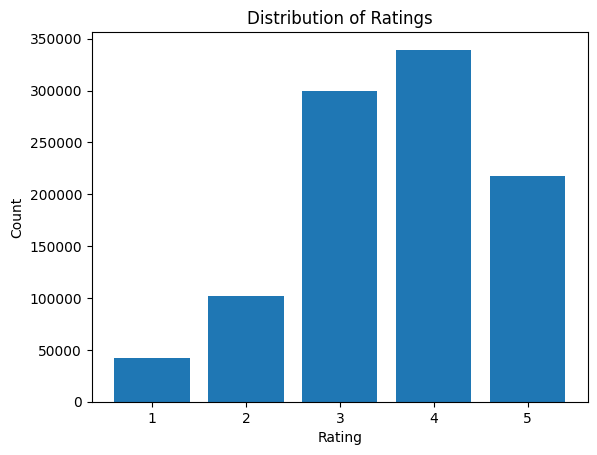

In [12]:
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'Ratings' and the column is called 'rating'
rating_counts = Ratings_sub['Rating'].value_counts()

# Create a bar plot
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [13]:
Ratings_sub = Ratings_sub[['User_ID', 'Movie_ID', 'Rating']] # reorder columns to match the order expected by surprise
Ratings_sub.head()

,User_ID,Movie_ID,Rating
16833062,873886,4369,5
12084659,1502456,3254,1
2936264,1712181,760,4
2864683,159549,758,3
13345255,1898635,3538,2


In [14]:
# Surprise reader
reader = Reader(rating_scale=(1, 5))

# Finally load all ratings
Ratings_reader = Dataset.load_from_df(Ratings_sub, reader)

# Collaborative Recommendation


In [ ]:
def get_rmse(algo, testset):
        predictions = algo.test(testset)
        accuracy.rmse(predictions, verbose=True)
kf = KFold(n_splits=3)

algos = [SVD(), NMF(), KNNBasic()] # , NMF(), KNNBasic()
for trainset, testset in tqdm(kf.split(Ratings_reader)):
    for algo in algos:
        algo.fit(trainset)
        get_rmse(algo, testset)

0it [00:00, ?it/s]

RMSE: 0.9775


# Content Based Filtering

In [16]:
Movies_subset = get_subset(Movies, 5000)
Movies_subset = Movies_subset.reset_index(drop=True)
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(Movies_subset['Name'])

In [21]:
# we get cosine similarities: this takes a lot of time on the real dataset
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [24]:
results = {}
for idx, row in Movies_subset.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], Movies_subset['Movie_ID'].loc[[i]].tolist()[0]) for i in similar_indices]
    results[idx] = similar_items[1:]

In [26]:
# transform a 'movieId' into its corresponding movie title
def item(id):
    return Movies_subset.loc[Movies_subset['Movie_ID'] == id]['Name'].tolist()[0].split(' - ')[0]

In [27]:
# transform a 'movieId' into the index id
def get_idx(id):
    return Movies_subset[Movies_subset['Movie_ID'] == id].index.tolist()[0]

In [28]:
# Finally we put everything together here:
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")
    print("-------")
    recs = results[get_idx(item_id)][:num]
    for rec in recs:
        print("\tRecommended: " + item(rec[1]) + " (score:" +      str(rec[0]) + ")")

In [35]:
recommend(item_id=17691, num=5)

Recommending 5 products similar to Red Dwarf: Series 3: Bonus Material...
-------
	Recommended: Red Dwarf: Series 2: Bonus Material (score:0.9999999999999999)
	Recommended: Red Dwarf: Series 3 (score:0.7129239657148871)
	Recommended: Red Dwarf: Series 5 (score:0.7129239657148871)
	Recommended: Red Dwarf: Series 2 (score:0.7129239657148871)
	Recommended: O: Bonus Material (score:0.3734878911315429)


In [40]:
from itertools import islice
for key, value in islice(results.items(), 100):
    print(key, value)

0 [(0.3870967332520682, 9465), (0.3851915778478396, 4658), (0.300702407261454, 2296), (0.2995126479926285, 14348), (0.26459511149721465, 14171), (0.23494004763104376, 10081), (0.22531320730768056, 13335), (0.15653312171678915, 5516), (0.14883212197245602, 11152), (0.14624427312626667, 11763), (0.14440537997434993, 12639), (0.14440537997434993, 11400), (0.14181731307032827, 8392), (0.14181731307032827, 7022), (0.1399880096206272, 12057), (0.13742563009488254, 8528), (0.13742563009488254, 8445), (0.13742563009488254, 1489), (0.13742563009488254, 14217), (0.13450916821950254, 13549), (0.1066908536232576, 13545), (0.10269832866920137, 15683), (0.09977234598802326, 7124), (0.09582617599645805, 3112), (0.09533198010983447, 3176), (0.09410847521437678, 9797), (0.09370139370170945, 639), (0.07776008448829631, 16030), (0.07651532241747415, 7507), (0.06773935047064028, 13558), (0.0, 1332), (0.0, 5353), (0.0, 14823), (0.0, 17328), (0.0, 7527), (0.0, 7466), (0.0, 13920), (0.0, 1377), (0.0, 3296), 